In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the komega dataset 
df = pd.read_csv('/kaggle/input/ml-turbulence-dataset/komega.csv')

# Turbulence closure problem

## Basic problem
The continuity and Navier-Stokes equations make up **4 equations**, and have **4 unknowns** ($p$, $u_x$, $u_y$, $u_z$). They are closed, but are expensive to solve.
$$ \nabla \cdot \vec{u} = 0$$
$$\nabla \cdot (\vec{u}\vec{u}) = - \nabla p + \nu \nabla^2\vec{u} $$
If we write these equations in terms of **averaged fields** instead, they are much cheaper to solve. We get the continuity and Reynolds-averaged Navier-Stokes equations:
$$ \nabla \cdot \vec{U} = 0$$
$$\nabla \cdot (\vec{U}\vec{U}) = - \nabla p + \nu \nabla^2\vec{U} - \nabla \cdot \tau$$


But now, we have additional unknown: $\tau$, the **Reynolds stress tensor**. The equations are **unclosed** - we have more unknowns than equations. 

We need to close the equations by expressing $\tau$ in terms of $P$, $U_x$, $U_y$, and $U_z$:

$$\tau = \tau (P, U_x, U_y,U_z)$$

The usual method to close these equations is something like this (the standard $k$-$\omega$ model):
$$
\tau = -2\nu_t S + \tfrac{2}{3}kI\\
\nu_t = \frac{k}{\omega}\\
k \text{ transport equation}\\
\omega \text{ transport equation}\\
$$

This method is called *physics-based*: we construct a closure model from physical arguments and assumptions about how the mean velocity field is related to the Reynolds stress field.

Using a *data-driven* model, we can correct the Reynolds stress field predicted by the physics-based model. Then, these corrections can be used to make the $\vec{U}$ and $p$ fields more accurate. **Our goal is to train ML models to predict an accurate value of $\tau$, given RANS flow fields from a $k$-$\omega$ simulation.** After creating this neural network, we could use it within a CFD simulation to correct the $k$-$\omega$ closure. 



# The ML turbulence dataset

This dataset contains a set of collocated RANS and DNS/LES flow fields, for several different flows.

In [3]:
df.describe()

,Unnamed: 0,komega_Cx,komega_Cy,komega_Cz,komega_Ux,komega_Uy,komega_Uz,komega_p,komega_omega,komega_epsilon,...,labels_tau_33,labels_um,labels_vm,labels_wm,labels_uu,labels_uv,labels_uw,labels_vv,labels_vw,labels_ww
count,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,8.956400e+05,8.956400e+05,8.956400e+05,8.956400e+05,...,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,895640.000000,8.956400e+05,8.956400e+05,8.956400e+05,895640.000000
mean,40478.489758,3.946571,0.684325,0.113767,5.402107,-0.088094,9.269814e-12,-3.535149e+00,1.412501e+04,1.876916e+02,...,0.402464,5.608039,-0.094093,-0.000001,0.705201,-0.204549,-1.359287e-06,2.871643e-01,-6.072674e-09,0.402464
std,41498.600104,5.600255,1.348276,0.198281,7.022020,0.954222,5.734052e-11,1.934176e+01,2.173288e+05,7.052611e+02,...,0.906041,7.318170,0.978417,0.001320,1.582177,0.540844,1.182863e-04,7.087897e-01,1.379124e-05,0.906041
min,0.000000,-7.264670,-0.498505,-0.498505,-2.324270,-3.306060,-7.404760e-10,-1.156080e+02,1.760090e-02,1.515230e-10,...,0.000000,-1.877020,-4.018943,-0.017167,0.000000,-4.367508,-9.489061e-04,3.161123e-14,-2.127504e-04,0.000000
25%,7721.000000,0.273305,0.019601,0.025000,0.374372,-0.091301,-1.386665e-23,-1.311517e-01,2.012923e+00,5.116180e-04,...,0.000114,0.416454,-0.092677,0.000000,0.001802,-0.124215,-3.544694e-07,1.920675e-04,0.000000e+00,0.000114
50%,28326.000000,1.250000,0.096835,0.050000,0.921961,-0.000054,0.000000e+00,-1.223980e-11,2.308175e+01,6.179465e-03,...,0.002146,0.955644,-0.000999,0.000000,0.007715,-0.000293,0.000000e+00,1.500282e-03,0.000000e+00,0.002146
75%,59061.000000,6.606607,1.016360,0.250000,12.726500,0.000333,4.572100e-22,2.878685e-02,4.424367e+02,3.294505e+01,...,0.338569,12.607413,0.001438,0.000000,0.585165,0.000005,0.000000e+00,1.991498e-01,2.449383e-08,0.338569
max,183711.000000,25.305400,9.479090,0.505000,21.076300,5.665470,1.119430e-09,6.238560e+01,6.692830e+06,1.842930e+04,...,6.920628,22.991733,5.944644,0.015958,12.904184,1.516789,1.053177e-03,6.061361e+00,3.113538e-04,6.920628


In [4]:
print('Dataframe columns:\nkomega prefix means the field is from komega, label prefix means the field is from DNS/LES\n')
print(df.columns.to_list())

print('\nFlows in the dataset:\n')
print(df.Case.unique())

Dataframe columns:
komega prefix means the field is from komega, label prefix means the field is from DNS/LES

['Unnamed: 0', 'komega_Cx', 'komega_Cy', 'komega_Cz', 'komega_Ux', 'komega_Uy', 'komega_Uz', 'komega_p', 'komega_omega', 'komega_epsilon', 'komega_k', 'komega_gradU_11', 'komega_gradU_12', 'komega_gradU_13', 'komega_gradU_21', 'komega_gradU_22', 'komega_gradU_23', 'komega_gradU_31', 'komega_gradU_32', 'komega_gradU_33', 'komega_gradpx', 'komega_gradpy', 'komega_gradpz', 'komega_gradkx', 'komega_gradky', 'komega_gradkz', 'komega_S_11', 'komega_S_12', 'komega_S_13', 'komega_S_22', 'komega_S_23', 'komega_S_33', 'komega_Shat_11', 'komega_Shat_12', 'komega_Shat_13', 'komega_Shat_22', 'komega_Shat_23', 'komega_Shat_33', 'komega_R_11', 'komega_R_12', 'komega_R_13', 'komega_R_21', 'komega_R_22', 'komega_R_23', 'komega_R_31', 'komega_R_32', 'komega_R_33', 'komega_Rhat_11', 'komega_Rhat_12', 'komega_Rhat_13', 'komega_Rhat_21', 'komega_Rhat_22', 'komega_Rhat_23', 'komega_Rhat_31', 'komeg

Let's visualize some fields for one of the periodic hills.

In [5]:
df_phll = df[df.Case == 'PHLL_case_1p0']

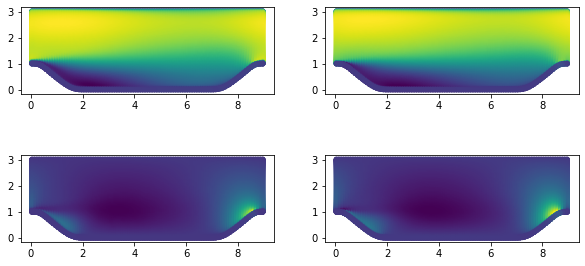

In [6]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,5))

ax[0,0].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_um'],s=20)
ax[0,0].set_aspect(1)

ax[1,0].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['labels_vm'],s=20)
ax[1,0].set_aspect(1)

ax[0,1].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['komega_Ux'],s=20)
ax[0,1].set_aspect(1)

ax[1,1].scatter(df_phll['komega_Cx'],df_phll['komega_Cy'],c=df_phll['komega_Uy'],s=20)
ax[1,1].set_aspect(1)


First, we will train a "vanilla" Neural Network. We'll focus on trying to predict one component of the DNS Reynolds stress tensor ($\tau_{xx}$), using flow fields from a $k$-$\omega$ RANS simulation. To start, let's pick a few input features, and train our first neural network.

Input to the neural network:
$$
\begin{bmatrix}
           I_1(B_1) \\
           I_1(B_2) \\
           I_2(B_7) \\
           I_1(B_{27}) \\
           I_2(B_1) \\
           I_2(B_2) 
         \end{bmatrix}$$
        
Output from the neural network:
$$
\begin{bmatrix}
           \tau_{xx} \\
         \end{bmatrix}$$

In [7]:
#Training/validation/test split
df_train = df[(df.Case.isin(['PHLL_case_0p5','PHLL_case_0p8','PHLL_case_1p5']))]
df_val = df[df.Case == 'PHLL_case_1p0']
df_test = df[df.Case == 'PHLL_case_1p2']

In [8]:
features = ['komega_I1_1','komega_I2_1','komega_I1_2','komega_I2_2','komega_I1_27','komega_I2_7']
label = ['labels_uu']

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
df_train = df[(df.Case.isin(['PHLL_case_0p5','PHLL_case_0p8','PHLL_case_1p5']))]
df_val = df[df.Case == 'PHLL_case_1p0']
df_test = df[df.Case == 'PHLL_case_1p2']

def preprocess_dataset(df,features,labels):
    df_train = df[(df.Case.isin(['PHLL_case_0p5','PHLL_case_0p8','PHLL_case_1p5']))]
    df_val = df[df.Case == 'PHLL_case_1p0']
    df_test = df[df.Case == 'PHLL_case_1p2']
        
    train_features = torch.Tensor(df_train[features].values)
    train_labels = torch.Tensor(df_train[labels].values)
    
    val_features = torch.Tensor(df_val[features].values)
    val_labels = torch.Tensor(df_val[labels].values)
    
    test_features = torch.Tensor(df_test[features].values)
    test_labels = torch.Tensor(df_test[labels].values)
    
    feature_scaler = StandardScaler()
    x_train = torch.Tensor(feature_scaler.fit_transform(train_features))
    x_val = torch.Tensor(feature_scaler.transform(val_features))
    x_test = torch.Tensor(feature_scaler.transform(test_features))

    label_scaler = StandardScaler()
    y_train = torch.Tensor(label_scaler.fit_transform(train_labels))
    y_val = torch.Tensor(label_scaler.transform(val_labels))
    y_test = torch.Tensor(label_scaler.transform(test_labels))    
    return x_train, y_train, x_val, y_val, x_test, y_test, feature_scaler, label_scaler


def evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, label_scaler):
    fig = plt.figure(figsize=(15,5),constrained_layout=True)
    gs = fig.add_gridspec(2,2,hspace=0.,wspace=0.1)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[0,1])
    ax4 = fig.add_subplot(gs[1,1])
    
    model.eval()
    
    train_predictions = model.forward(x_train)
    val_predictions = model.forward(x_val)
    test_predictions = model.forward(x_test)
    
    print(f'Training set score: {mean_squared_error(label_scaler.inverse_transform(y_train),label_scaler.inverse_transform(train_predictions.detach().numpy()))}')
    print(f'Validation set score: {mean_squared_error(label_scaler.inverse_transform(y_val),label_scaler.inverse_transform(val_predictions.detach().numpy()))}')
    print('=========================')
    print(f'TEST SET SCORE: {mean_squared_error(label_scaler.inverse_transform(y_test),label_scaler.inverse_transform(test_predictions.detach().numpy()))}\n')

    
    ax1.tricontourf(df_val['komega_Cx'],df_val['komega_Cy'],label_scaler.inverse_transform(val_predictions.detach().numpy())[:,0],vmax=5E-5,vmin=-5E-5)
    ax1.set_aspect(1)
    ax1.set_title('Predictions - validation set')
    ax2.tricontourf(df_val['komega_Cx'],df_val['komega_Cy'],df_val['labels_uu'],vmax=5E-5,vmin=-5E-5)
    ax2.set_aspect(1)
    ax2.set_title('Truth - validation set')
    ax3.tricontourf(df_test['komega_Cx'],df_test['komega_Cy'],label_scaler.inverse_transform(test_predictions.detach().numpy())[:,0],vmax=5E-5,vmin=-5E-5)
    ax3.set_aspect(1)
    ax3.set_title('Predictions - test set')
    ax4.tricontourf(df_test['komega_Cx'],df_test['komega_Cy'],df_test['labels_uu'],vmax=5E-5,vmin=-5E-5)
    ax4.set_aspect(1)
    ax4.set_title('Truth - test set')


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

def construct_neural_network(n_features, output_size, num_hidden_layers, num_neurons):
    layers = [n_features]
    for i in range(num_hidden_layers):
        layers.append(num_neurons)
    layers.append(output_size)
    activation_fn = nn.ReLU()
    model_layers = []
    for i in range(len(layers)):
        
        if i < len(layers) - 2:   
            model_layers.append(nn.Linear(layers[i], layers[i + 1]))
            model_layers.append(activation_fn)
        
        elif i == len(layers) - 2:
            model_layers.append(nn.Linear(layers[i], output_size))
    
    model = nn.Sequential(*model_layers)
    print(model)
    
    return model


def train_neural_network(model, x_train, y_train, x_val, y_val, n_epochs):
    
    optimiser = optim.SGD(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    
    train_set = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    
    val_set = TensorDataset(x_val, y_val)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
    
    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            predicted_y = model.forward(x_batch)
            train_loss = loss_fn(predicted_y, y_batch)

            optimiser.zero_grad()
            train_loss.backward()
            optimiser.step()

        model.eval()
        for x_batch, y_batch in val_loader:
            predicted_y = model.forward(x_batch)
            val_loss = loss_fn(predicted_y, y_batch)

        print(f'Epoch: {epoch}, training loss: {train_loss}, validation loss: {val_loss}')


In [11]:
features = ['komega_I1_1','komega_I2_1','komega_I1_2','komega_I2_2','komega_I1_27','komega_I2_7']
labels = ['labels_uu']
x_train, y_train, x_val, y_val, x_test, y_test, feature_scaler, label_scaler = preprocess_dataset(df,features,labels)

model = construct_neural_network(len(features),
                                 output_size=1,
                                 num_hidden_layers=3,
                                 num_neurons=10)

train_neural_network(model, x_train, y_train, x_val, y_val, n_epochs=20)

Sequential(
  (0): Linear(in_features=6, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)
Epoch: 0, training loss: 0.26799526810646057, validation loss: 0.706119179725647
Epoch: 1, training loss: 0.521751344203949, validation loss: 0.6902972459793091
Epoch: 2, training loss: 0.49237337708473206, validation loss: 0.294335275888443
Epoch: 3, training loss: 0.3295895755290985, validation loss: 0.24890653789043427
Epoch: 4, training loss: 0.5762303471565247, validation loss: 0.2672479450702667
Epoch: 5, training loss: 0.1918342262506485, validation loss: 0.3607097268104553
Epoch: 6, training loss: 0.461943119764328, validation loss: 0.30703499913215637
Epoch: 7, training loss: 0.29721906781196594, validation loss: 0.25122323632240295
Epoch: 8, training loss: 0.5081911087036133, validation loss: 0.

Training set score: 1.3310566168611847e-10
Validation set score: 1.0027744064085187e-10
TEST SET SCORE: 1.0706427975173296e-10



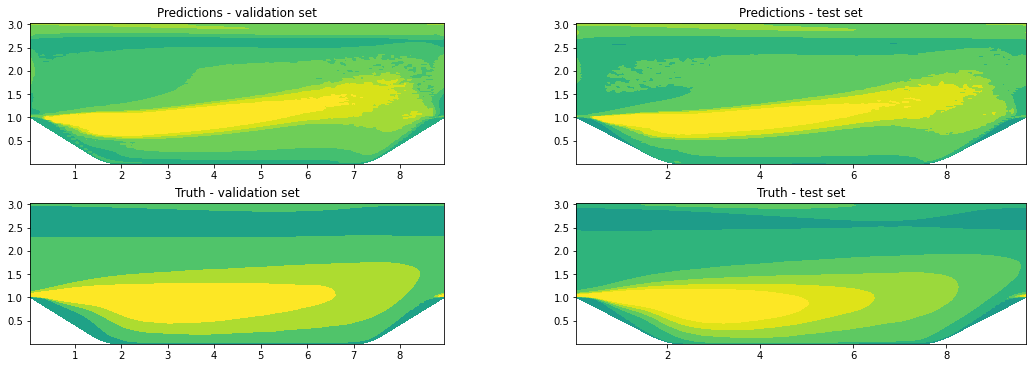

In [12]:
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, label_scaler)